In [2]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

from IPython.display import clear_output
import matplotlib.pyplot as plt


In [3]:
def ac(circ, g_cu, g_ox, c_ox, w):
    # ac analysis of the circuit

    # resistance and capacitance from the center of each cell
    # to the edge of the node
    g = circ * 0.5 * g_cu + (1 - circ) * 0.5 * g_ox
    c = (1 - circ) * 0.5j * c_ox

    y = g + w * c
    y = y.flatten()

    # admittance from center of this node to neighbouring nodes
    size = circ.shape[0]
    y_tot1 = torch.reciprocal(torch.reciprocal(y[size:]) + torch.reciprocal(y[:-size]))
    y_tot2 = torch.reciprocal(torch.reciprocal(y[1:]) + torch.reciprocal(y[:-1]))

    count = size * size
    A = torch.zeros((count, count), dtype=torch.cfloat)

    A = torch.diagonal_scatter(A, y_tot1, size)
    A = torch.diagonal_scatter(A, y_tot2, 1)
    A = torch.diagonal_scatter(A, y_tot2, -1)
    A = torch.diagonal_scatter(A, y_tot1, -size)

    # driving point admittance
    Yjw = torch.sum(A, dim=1)
    A = A / Yjw[:,None]

    # clamp to avoid numerical issues
    A = torch.complex(torch.clamp(A.real, 0, 0.99999), A.imag)

    # boundary conditions
    boundary = torch.zeros(circ.shape)
    boundary[0, :] = 1
    boundary[:, 0] = 1
    boundary[-1, :] = 1
    boundary[:, -1] = 1
    boundary = boundary.flatten()
    indices = torch.argwhere(boundary)

    A[indices, :] = 0
    A.fill_diagonal_(-1)

    # b=0 to eliminate divergence: I_in = I_out
    b = torch.zeros(count, dtype=torch.cfloat)

    return A, b

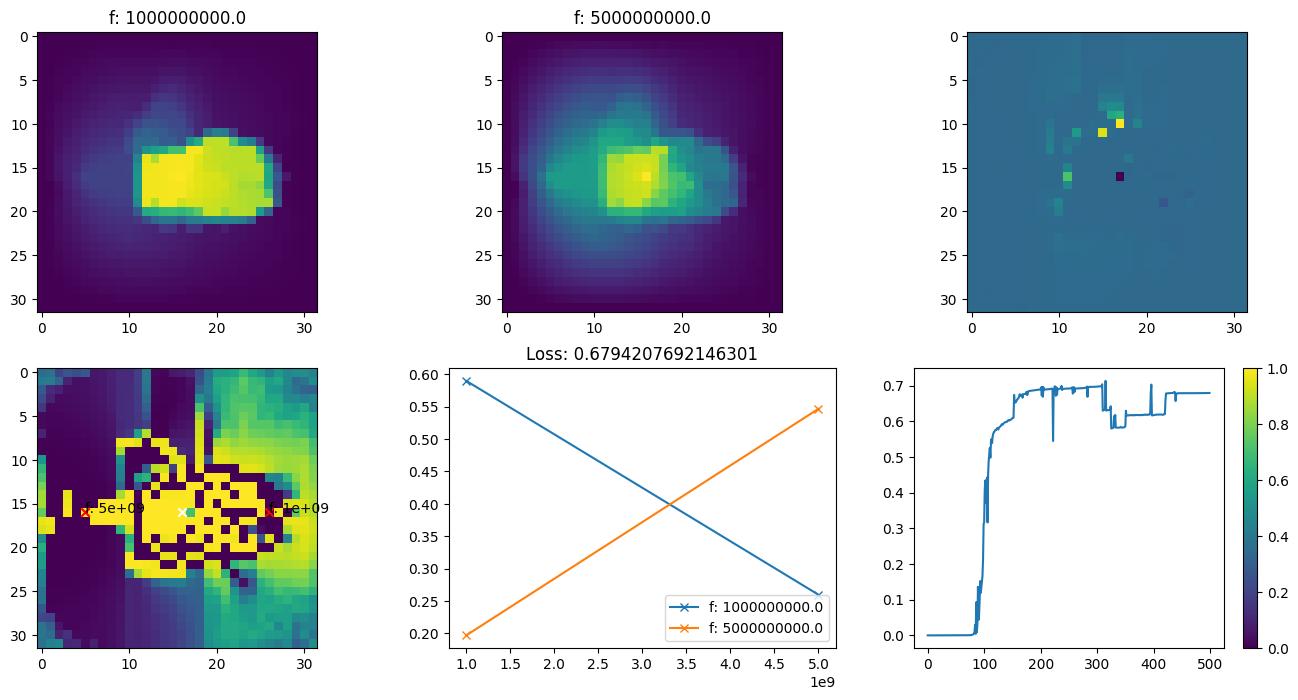

In [ ]:
epr_ox = 200
ep_vac = 1.257e-6
pitch = 5e-9
k_ox = epr_ox * ep_vac
c_ox = pitch * k_ox
r_cu = 1.724e-8 / pitch
r_ox = 1e16 / pitch

print(f"Oxide Capacitance: {c_ox} F/cell")
print(f"Copper conductance: {1 / r_cu} S/cell")
print(f"Oxide Conductance: {1 / r_ox} S/cell")

size = 32
# torch.manual_seed(9)
circuit = torch.rand((size, size)) - 1
# circuit = -torch.ones((size, size))
# circuit[3:-3,3:-3] = 1

src = int(size / 2) * size + int(size / 2)

num_freqs = 2
port_radius = size / 3

ports = np.linspace(0, 2*torch.pi, num_freqs, endpoint=False)
px = torch.cos(torch.from_numpy(ports)) * port_radius + 0.5 * size
py = torch.sin(torch.from_numpy(ports)) * port_radius + 0.5 * size
port_indices = (py * size + px).int()

circuit[py.int(), px.int()] = 1
circuit[int(size / 2), int(size / 2)] = 1

# circuit[:,:] = 0
# circuit[1:-1, 0:2] = 1
# circuit[2:-2, 3:6] = 1
# circuit[int(size/2), 6:17] = 1

circuit.requires_grad = True

freq = torch.linspace(1e9, 5e9, num_freqs)
bin_width = freq[1] - freq[0]
H_target = torch.exp(-0.5 * torch.square((freq[None,...] - freq[..., None]) / (0.25 * bin_width)))
# H_target = torch.ones(H_target.shape)

step_size = 1000
criterion = nn.MSELoss()

losses = []

for i in range(500):
    rng = torch.rand(circuit.shape)
    rng[py.int(), px.int()] = -1e9
    rng[int(size / 2), int(size / 2)] = -1e9
    H = torch.zeros((num_freqs, num_freqs), dtype=torch.cfloat)
    #c = PsuedoHeaviside.apply(circuit)
    fig, ax = plt.subplots(2, 3, figsize=(17,8))
    for fi in range(num_freqs):
        A, b = ac(F.sigmoid(circuit), 1 / r_cu, 1 / r_ox, c_ox, freq[fi])

        # set input location to 1 V
        A[src] = 0
        A[src, src] = 1
        b[src] = 1

        v = torch.linalg.solve(A, b)
        H[:, fi] = v[port_indices]

        if fi in [0,1,2]:
            im = ax[0,fi].imshow(v.detach().reshape(circuit.shape).abs(), vmin=0, vmax=1)
            ax[0,fi].title.set_text(f'f: {freq[fi]}')

    H = H.abs()

    loss = torch.mean(H[0, 0] - H[0, 1] + H[1, 1] - H[1, 0])
    losses.append(loss.item())

    loss.backward()

    ax[0,2].imshow(circuit.grad.data.detach())
    im = ax[1,0].imshow(torch.sigmoid(circuit.detach()), vmin=0, vmax=1)
    ax[1,0].scatter(px.int().numpy(), py.int().numpy(), c='red', marker='x')
    ax[1,0].scatter([int(size/2)],[int(size/2)], c='white', marker='x')

    circuit.data = circuit.data + step_size * circuit.grad.data
    circuit.grad.data.zero_()

    for i in range(num_freqs):
        ax[1,0].text(px[i].int().numpy(), py[i].int().numpy(), f"f: {freq[i]:.2g}")

    fig.colorbar(im, ax=ax[1,2])

    for i in range(num_freqs):
        ax[1,1].plot(freq, H[i].detach().abs(), marker='x', label=f'f: {freq[i]}')
        # ax[1,1].plot(freq, H_target[i], marker='o')
        ax[1,1].title.set_text(f'Loss: {loss.item()}')

    ax[1,1].legend()
    ax[1,2].plot(losses)

    clear_output(wait=True)
    plt.show()